<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Convolutional Neural Network (CNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.10.0+cu111].
device:[cuda:0].


### Dataset

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [14]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self,name='cnn',xdim=[1,28,28],
                 ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,
                 USE_BATCHNORM=False):
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM

        self.layers = [] # 여기에 components들을 정의해서 넣을 것임
        # Convolutional layers
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # for each hidden layer
            self.layers.append(
                # convlution 
                nn.Conv2d(in_channels = prev_cdim, 
                          out_channels = cdim,
                          kernel_size = self.ksize,
                          stride = [1,1],
                          padding = self.ksize//2))
            
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm

            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling 
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
            prev_cdim = cdim

        # Dense layers
        self.layers.append(nn.Flatten()) # 마지막 conv feature map을 한 줄로 펴줌
        # 한줄로 폈을때, 몇개의 dimension인지 prev_hdim에 계산해서 넣음
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim, hdim, bias=True))
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim

        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers 
        # self.layers에 쌓은 components들을 하나씩 꺼내서 네트워크를 만든다.
        # 여기서 forward 메소드 역할을 해준거라고 생각하면 됨.
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            # add_module을 통해 하나씩 집어넣는다
            # add_module은 이름(변수명)을 정할 수 있는 장점이 있다.
            self.net.add_module(layer_name,layer)

        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self,x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(
    name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],
    hdims=[32],ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(),lr=1e-3)
print ("Done.")

Done.


In [12]:
C

ConvolutionalNeuralNetworkClass(
  (net): Sequential(
    (conv2d_00): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_01): ReLU(inplace=True)
    (maxpool2d_02): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout2d_03): Dropout2d(p=0.5, inplace=False)
    (conv2d_04): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_05): ReLU(inplace=True)
    (maxpool2d_06): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout2d_07): Dropout2d(p=0.5, inplace=False)
    (flatten_08): Flatten(start_dim=1, end_dim=-1)
    (linear_09): Linear(in_features=3136, out_features=32, bias=True)
    (relu_10): ReLU(inplace=True)
    (linear_11): Linear(in_features=32, out_features=10, bias=True)
  )
)

### Check Parameters

In [15]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[-0.64   0.991 -0.063  0.113 -0.628]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[ 0.004  0.081 -0.096  0.002 -0.213]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[ 0.025 -0.01   0.017  0.03  -0.035]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[ 0.102 -0.411 -0.133  0.093  0.027]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


### Simple Forward Path of the CNN Model

In [16]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.155, 0.173, 0.239,  ..., 0.715, 0.803, 0.290],
          [0.341, 0.298, 0.650,  ..., 0.766, 0.220, 0.607],
          [0.105, 0.953, 0.419,  ..., 0.068, 0.497, 0.482],
          ...,
          [0.057, 0.594, 0.529,  ..., 0.300, 0.369, 0.831],
          [0.368, 0.775, 0.642,  ..., 0.529, 0.700, 0.486],
          [0.092, 0.477, 0.318,  ..., 0.370, 0.400, 0.526]]],


        [[[0.901, 0.743, 0.127,  ..., 0.419, 0.161, 0.090],
          [0.125, 0.609, 0.497,  ..., 0.736, 0.607, 0.975],
          [0.580, 0.220, 0.613,  ..., 0.311, 0.836, 0.784],
          ...,
          [0.699, 0.632, 0.372,  ..., 0.057, 0.604, 0.605],
          [0.656, 0.638, 0.574,  ..., 0.735, 0.238, 0.637],
          [0.134, 0.389, 0.217,  ..., 0.664, 0.374, 0.555]]]], device='cuda:0')
y_torch:
 tensor([[-4.114, -0.735,  2.157,  0.140,  0.740, -0.356, -2.694, -1.786,  1.671,
         -2.628],
        [-3.502,  0.699,  3.316,  0.216, -0.937, -4.509, -5.683, -2.413, -0.359,
         -3.411]], device=

### Evaluation Function

In [17]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [18]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.101] test_accr:[0.101].


### Train

In [19]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 중요! (dropout, BN 적용)
EPOCHS,print_every = 10,1

for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()     # reset gradient 
        loss_out.backward()  # backpropagate
        optm.step()          # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.502] train_accr:[0.960] test_accr:[0.964].
epoch:[1] loss:[0.156] train_accr:[0.976] test_accr:[0.977].
epoch:[2] loss:[0.111] train_accr:[0.983] test_accr:[0.984].
epoch:[3] loss:[0.091] train_accr:[0.986] test_accr:[0.984].
epoch:[4] loss:[0.081] train_accr:[0.988] test_accr:[0.987].
epoch:[5] loss:[0.073] train_accr:[0.990] test_accr:[0.987].
epoch:[6] loss:[0.066] train_accr:[0.992] test_accr:[0.989].
epoch:[7] loss:[0.060] train_accr:[0.992] test_accr:[0.989].
epoch:[8] loss:[0.056] train_accr:[0.992] test_accr:[0.989].
epoch:[9] loss:[0.056] train_accr:[0.993] test_accr:[0.990].
Done


### Test

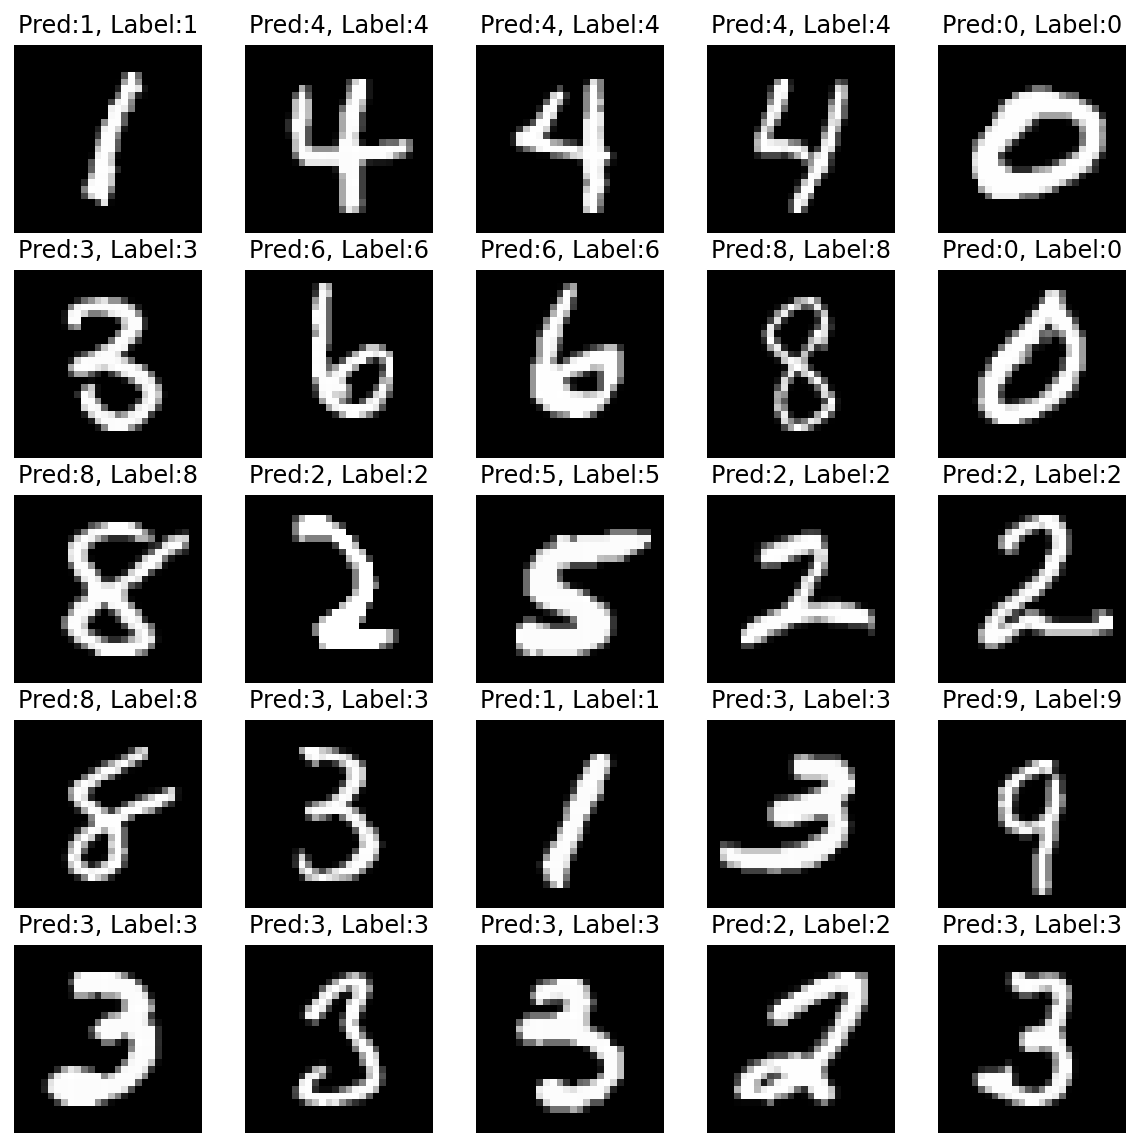

Done


In [20]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")